<h1><center>Transfer Learning with data augmentation</center></h1>

### Autor
- Nombre: Edwin Jahir Rueda Rojas
- email: ejrueda95g@gmail.com

- La finalidad de este notebook es aumentar un conjunto de imagenes por medio de rotaciones y aplicando zoom, para después entrenar la red neuronal convolucional propuesta en el taller 0 (<b>T0 - transfer learning with image generator.ipynb</b>)-
- Aplicar esta técnica de aumento de imágenes permite que el modelo que se construye sea mas generalizado, haciendo que su accuracy aumente en los datos de validación.

In [1]:
from PIL import Image
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from time import time
%matplotlib inline

#### Cargar los datos
- Note que los datos se cargan con un generador de tensorflow, esto en realidad no carga el dataset a la memoria RAM, simplemente crea <b>batches</b> los cuales en el momento de entrenar se cargan uno a uno, permitiendo consumir muy poca RAM.

In [2]:
batch_size = 64
img_height = 145
img_width = 145
data_root='../data/archive/raw-img/'
print("datos de entrenamiento")
data_train = tf.keras.preprocessing.image_dataset_from_directory(str(data_root),
                                                               validation_split=0.8,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size,
                                                               label_mode='categorical')

print("datos de validación")
data_test = tf.keras.preprocessing.image_dataset_from_directory(str(data_root),
                                                               validation_split=0.2,
                                                               subset="validation",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size,
                                                               label_mode='categorical')

datos de entrenamiento
Found 30349 files belonging to 11 classes.
Using 6070 files for training.
datos de validación
Found 30349 files belonging to 11 classes.
Using 6069 files for validation.


tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(11,), dtype=float32)


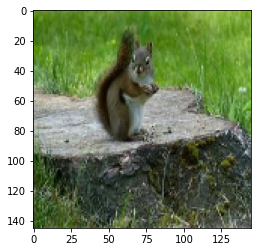

In [3]:
for i, c in data_train:
    plt.imshow(i[0]/255)
    print(c[0])
    break

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

lblenc = LabelEncoder().fit_transform(data_train.class_names)
ohc = OneHotEncoder().fit_transform(lblenc.reshape(-1, 1) )

In [5]:
ohc.toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### Aumento de los datos
- Para aumentar el conjunto de datos utilizamos tres capas principales:
    - <b> RandomFlip:</b> Para rotar la imagen sobre el eje horizontal
    - <b> RandomRotation:</b> Para rotar la imagen por grados en sentido horario.
    - <b> RandomZoom: </b> Para hacerle un zoom aleatorio a la imágen

In [6]:
model_augmentation = tf.keras.Sequential(name="augmentation_model")
model_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
model_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(.1, fill_mode="constant"))
model_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(.2, fill_mode="constant"))

In [7]:
for img, label in data_train:
    print(img.shape, label.shape)
    img_pro, _ = model_augmentation(img), label
    print(img_pro.shape)
    break

(64, 145, 145, 3) (64, 11)
(64, 145, 145, 3)


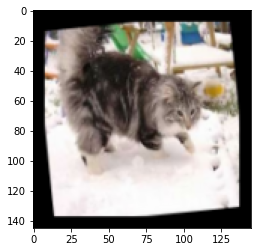

In [8]:
plt.imshow(img_pro[0]/255)

In [9]:
map_data_train = data_train.map(lambda x, y: (model_augmentation(x), y))

In [10]:
for img, label in map_data_train:
    print(img.shape, label.shape)
    break

(64, 145, 145, 3) (64, 11)


In [11]:
class_names = np.array(data_train.class_names)
print("categorias:", class_names)

categorias: ['cane' 'cavallo' 'elefante' 'farfalla' 'gallina' 'gatto' 'mucca' 'pecora'
 'ragno' 'scoiattolo' 'traffic_signals']


In [12]:
for image_batch, labels_batch in map_data_train:
    print("Tamaño del batch de entrenamiento:", image_batch.shape)
    print("Tamaño del label para el batch:", labels_batch.shape)
    break

Tamaño del batch de entrenamiento: (64, 145, 145, 3)
Tamaño del label para el batch: (64, 11)


- Se carga la CNN pre-entrenada de imagenet y se ajusta su dimensión de entrada.

In [13]:
tl_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                       input_shape=(img_height,img_width,3))

In [14]:
tl_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 145, 145, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 145, 145, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 145, 145, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 72, 72, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 72, 72, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 72, 72, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 36, 36, 128)       0     

In [23]:
tl_model._name = "deep_model"

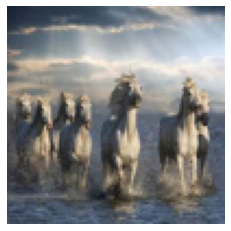

In [24]:
#img = Image.open("../data/archive/raw-img/gatto/465.jpeg").resize((100,100))
c = np.random.choice(os.listdir(data_root))
ruta_imagen = data_root + c + "/" + np.random.choice(os.listdir(data_root + c))
img = np.array(Image.open(ruta_imagen).resize((100,100)))
plt.imshow(img)
plt.axis("off");

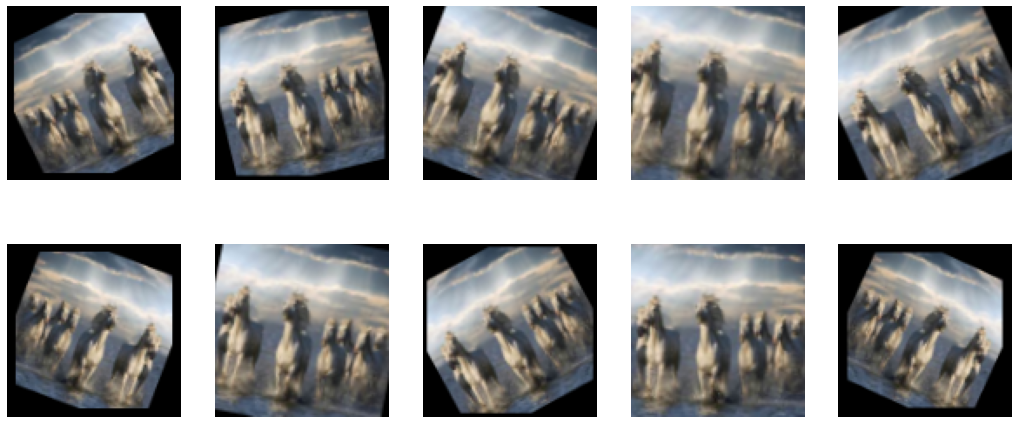

In [25]:
plt.figure(figsize=(18,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    img_pro = model_augmentation(np.array(img).reshape(1,100,100,3))
    plt.imshow(img_pro.numpy()[0]/255)
    plt.axis("off")

In [26]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(tl_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(.1))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(.1))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(.1))
model.add(tf.keras.layers.Dense(18, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics = ['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 145, 145, 3)       0         
_________________________________________________________________
deep_model (Functional)      (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

In [15]:
hist = model.fit(map_data_train, epochs=5, validation_data=data_test)

Epoch 1/5
48/48 [==============================] - 732s 15s/step - loss: 2.2616 - accuracy: 0.2357 - val_loss: 1.3610 - val_accuracy: 0.5547
Epoch 2/5
48/48 [==============================] - 725s 15s/step - loss: 1.3481 - accuracy: 0.5462 - val_loss: 1.0421 - val_accuracy: 0.6417
Epoch 3/5
48/48 [==============================] - 726s 15s/step - loss: 1.0724 - accuracy: 0.6348 - val_loss: 1.0586 - val_accuracy: 0.6365
Epoch 4/5
48/48 [==============================] - 726s 15s/step - loss: 0.9508 - accuracy: 0.6778 - val_loss: 0.8021 - val_accuracy: 0.7156
Epoch 5/5
48/48 [==============================] - 729s 15s/step - loss: 0.7587 - accuracy: 0.7515 - val_loss: 0.7921 - val_accuracy: 0.7386


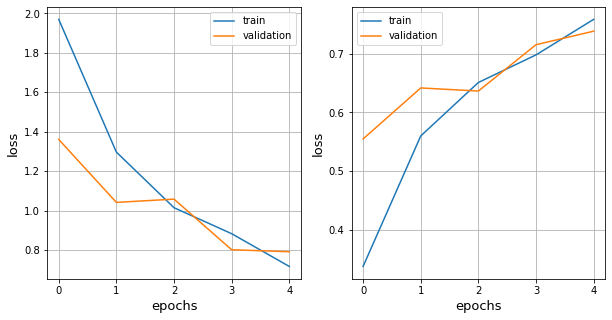

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("epochs", fontsize=13)
plt.ylabel("loss", fontsize=13)
plt.grid();

plt.subplot(1,2,2)
plt.plot(hist.history["accuracy"], label="train")
plt.plot(hist.history["val_accuracy"], label="validation")
plt.legend()
plt.xlabel("epochs", fontsize=13)
plt.ylabel("loss", fontsize=13)
plt.grid();

- guardamos los datos importantes

In [17]:
model.save("../models_aug/")

INFO:tensorflow:Assets written to: ../models_aug/assets


- ejecutamos el archivo <b>prediction.py</b> el cual nos sirve para predecir en base a un modelo

In [18]:
%run prediction.py

<Figure size 432x288 with 0 Axes>

In [19]:
cnn = cnn_images_10(ruta_modelo="../models_aug/", ruta_translate="../translate.pk",
                   ruta_class="../class_name.pk")

ValueError: num must be 1 <= num <= 10, not 11

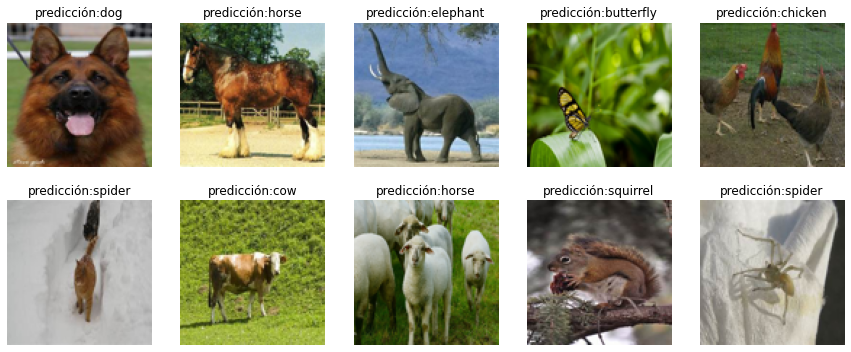

In [20]:
root='../data/archive/raw-img/'
plt.figure(figsize=(15,6))
count = 1
for c in cnn.translate.keys():
    #selecciono una ruta de imagen aleatoria
    ruta_imagen = np.random.choice(os.listdir("../data/archive/raw-img/" + c))
    plt.subplot(2,5,count)
    #print(root + ruta_imagen)
    ruta_completa = root + c + "/" + ruta_imagen
    plt.imshow(np.asarray(Image.open(ruta_completa).resize((100,100))))
    plt.axis("off")
    prediction = cnn.predict(ruta_completa)
    plt.title("predicción:"+ prediction[0])
    count += 1

(100, 100, 3)


'pecora'

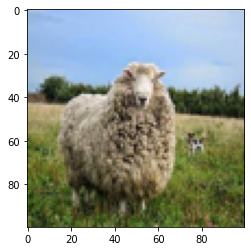

In [61]:
img = np.asarray(Image.open("../data/archive/raw-img/pecora/OIP--CqWh6W1NLb76TYL4OCGAAHaFi.jpeg").resize((100,100)))
print(img.shape)
plt.imshow(img)
class_names[np.argmax(model(img.reshape((1,100,100,3))).numpy()[0])]

- por si no son a color las imágenes

In [79]:
img_gris = np.mean(img.numpy()[0], axis=2)
img_gris.shape

(100, 100)

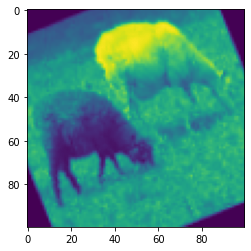

In [81]:
plt.imshow(img_gris)

In [105]:
stacked_img = np.stack((img_gris,)*3, axis=-1)


In [107]:
len(stacked_img.shape)

3